In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import pandas as pd
import yfinance as yf
from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.optimize as sco

In [2]:
tickers = ['AAPL', 'BAC', 'INTC', 'GME', 'BA', 'BABA', 'UA', 'KO', 'NVDA', 'META']

In [3]:
data = yf.download(tickers, start = '2018-01-01', end = '2021-01-01', group_by = 'ticker', threads = True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [4]:
data.stack()

C:\Users\dfdop\AppData\Local\Temp\ipykernel_13800\2489631911.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data.stack()


Ticker                     META           UA          BABA           BAC  \
Date       Price                                                           
2018-01-02 Close   1.805690e+02       13.970  1.773594e+02  2.519165e+01   
           High    1.807282e+02       14.010  1.777940e+02  2.519165e+01   
           Low     1.767171e+02       13.230  1.696817e+02  2.494731e+01   
           Open    1.768465e+02       13.450  1.703567e+02  2.506527e+01   
           Volume  1.815190e+07  6264809.000  2.991690e+07  5.712160e+07   
...                         ...          ...           ...           ...   
2020-12-31 Close   2.718786e+02       14.880  2.247582e+02  2.731158e+01   
           High    2.757902e+02       15.113  2.307362e+02  2.738367e+01   
           Low     2.685443e+02       14.810  2.231135e+02  2.694214e+01   
           Open    2.707241e+02       15.010  2.293262e+02  2.704126e+01   
           Volume  1.290040e+07  1981656.000  2.345180e+07  2.871600e+07   

Ticker                       KO          INTC           GME            BA  \
Date       Price                                                            
2018-01-02 Close   3.627221e+01  3.933039e+01  3.988464e+00  2.828864e+02   
           High    3.659081e+01  3.937236e+01  3.995017e+00  2.830293e+02   
           Low     3.624832e+01  3.879311e+01  3.883620e+00  2.815140e+02   
           Open    3.656691e+01  3.893583e+01  3.922936e+00  2.818476e+02   
           Volume  1.087220e+07  2.337080e+07  1.133080e+07  2.978900e+06   
...                         ...           ...           ...           ...   
2020-12-31 Close   4.821766e+01  4.503854e+01  4.710000e+00  2.140600e+02   
           High    4.829679e+01  4.537303e+01  4.950000e+00  2.169000e+02   
           Low     4.771649e+01  4.404411e+01  4.700000e+00  2.127000e+02   
           Open    4.787475e+01  4.407123e+01  4.812500e+00  2.162400e+02   
           Volume  8.495000e+06  2.857680e+07  2.769080e+07  1.048760e+07   

Ticker                     AAPL          NVDA  
Date       Price                               
2018-01-02 Close   4.047985e+01  4.929427e+00  
           High    4.048925e+01  4.933136e+00  
           Low     3.977487e+01  4.809499e+00  
           Open    3.998636e+01  4.841149e+00  
           Volume  1.022236e+08  3.556160e+08  
...                         ...           ...  
2020-12-31 Close   1.296091e+02  1.302075e+01  
           High    1.316115e+02  1.311650e+01  
           Low     1.286616e+02  1.288112e+01  
           Open    1.309668e+02  1.310204e+01  
           Volume  9.911660e+07  1.924240e+08  

[3780 rows x 10 columns]

<Axes: xlabel='Date'>

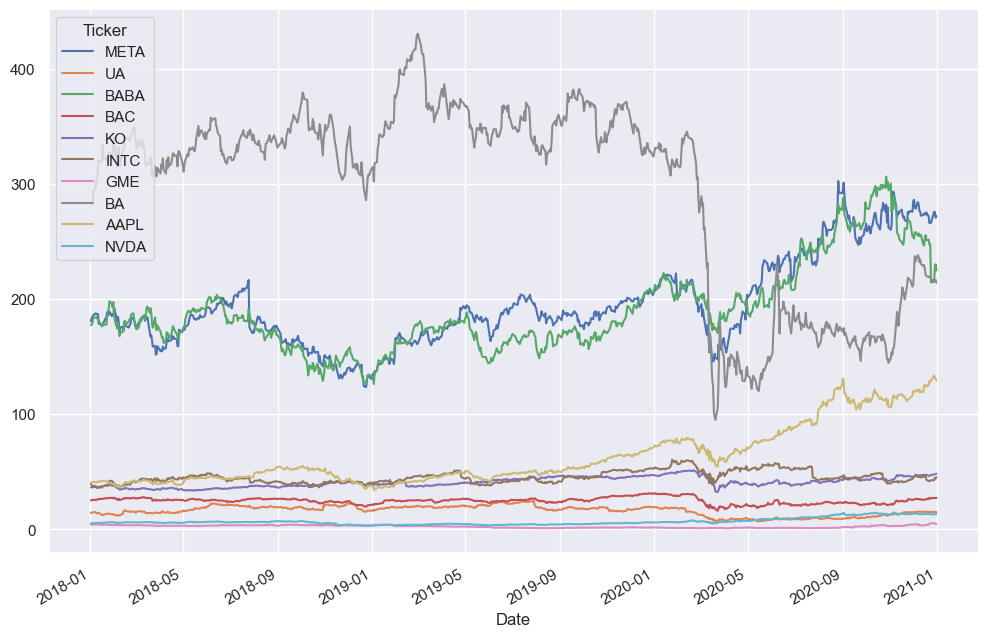

In [5]:
close_prices = data.xs('Close', axis = 1, level = 1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

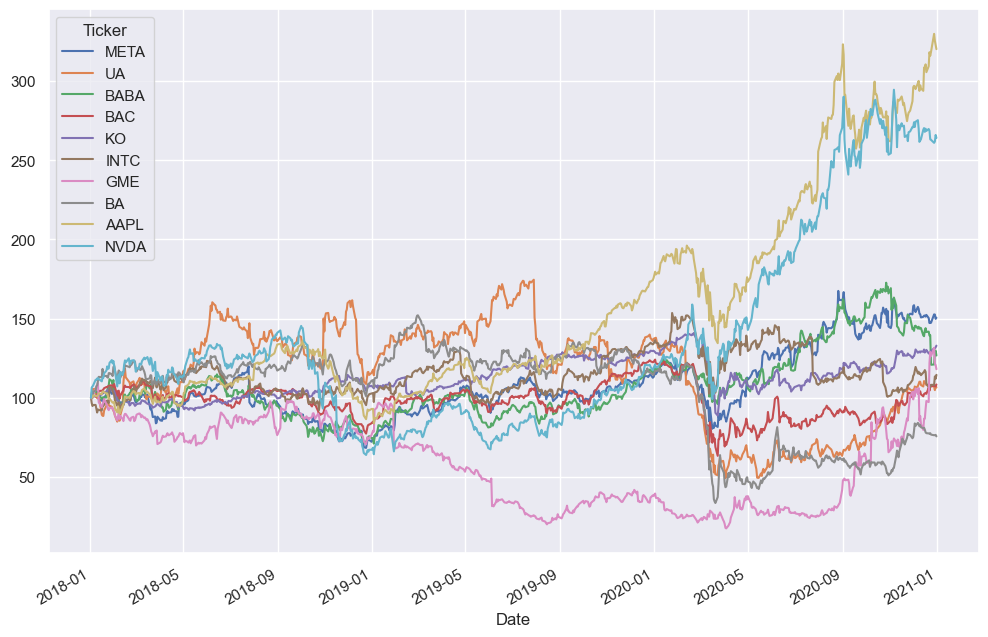

In [6]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize = (12, 8))

In [7]:
simple_retunrs = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

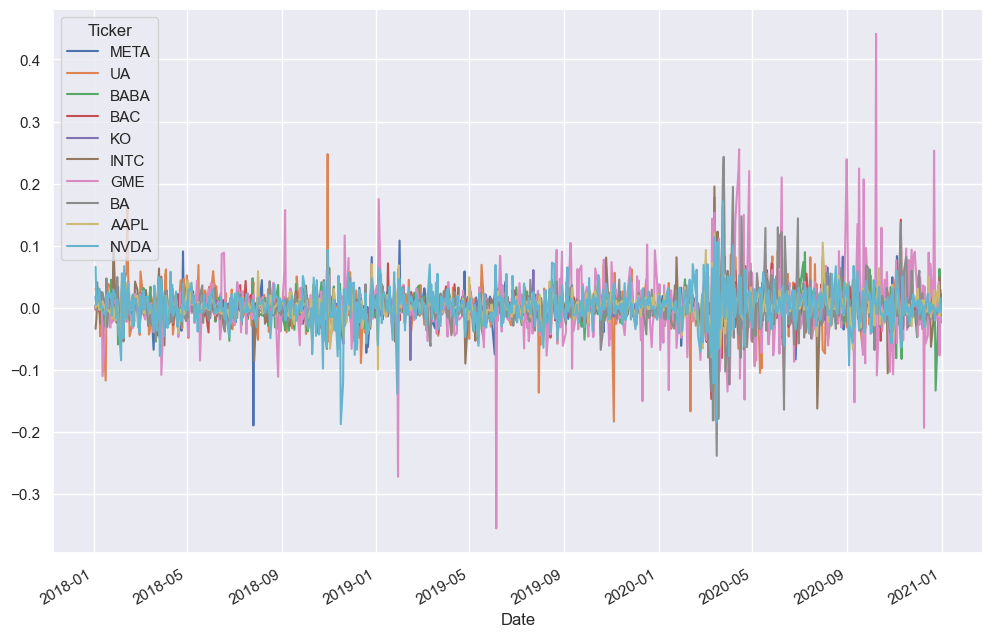

In [8]:
simple_retunrs.plot(kind = 'line', figsize = (12, 8))

In [9]:
daily_returns = simple_retunrs.mean()
daily_risk = simple_retunrs.std()

In [10]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 - 1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [11]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

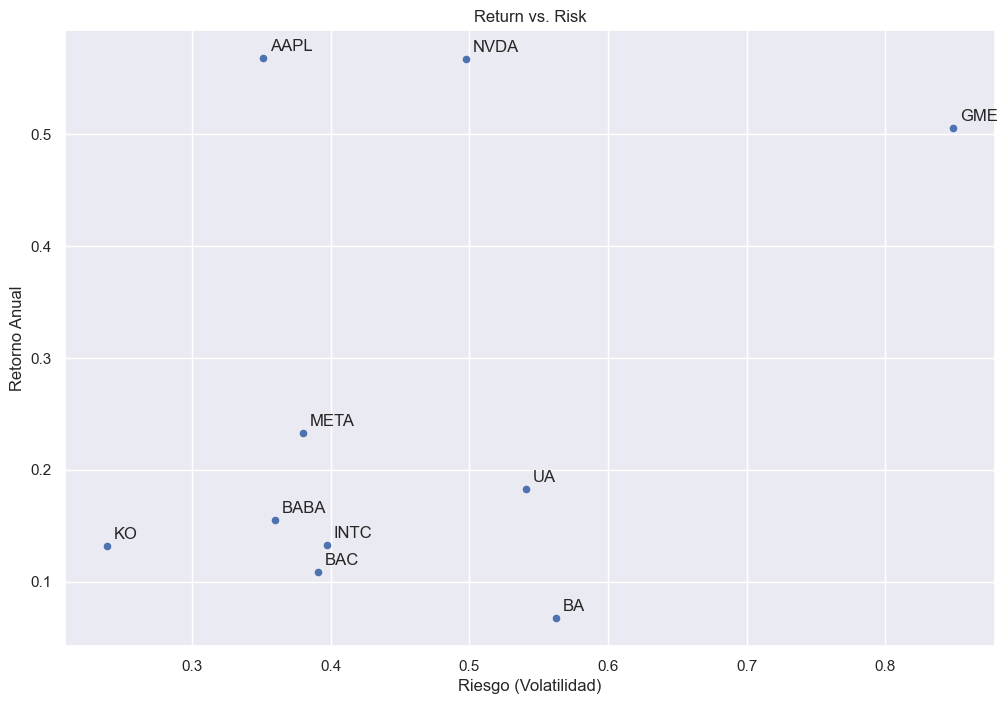

In [12]:
ax = return_risk.plot(
    kind = 'scatter',
    x = 'yearly_risk',
    y = 'yearly_returns',
    figsize = (12, 8),
    title = 'Return vs. Risk'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext = (5, 5),
        textcoords = 'offset points'
    )
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

Calculando la frontera eficiente por medio de simulacion

In [13]:
cov_matrix = simple_retunrs.cov().to_numpy()*252
exp_returns = yearly_returns.to_numpy()

n_portfolios = 250000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, exp_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = port_std*100
    results[1, i] = port_return*100
    # Compute Sharp Ratio with a free risk iquals zero
    results[2, i] = (port_return - 0.0178) / port_std


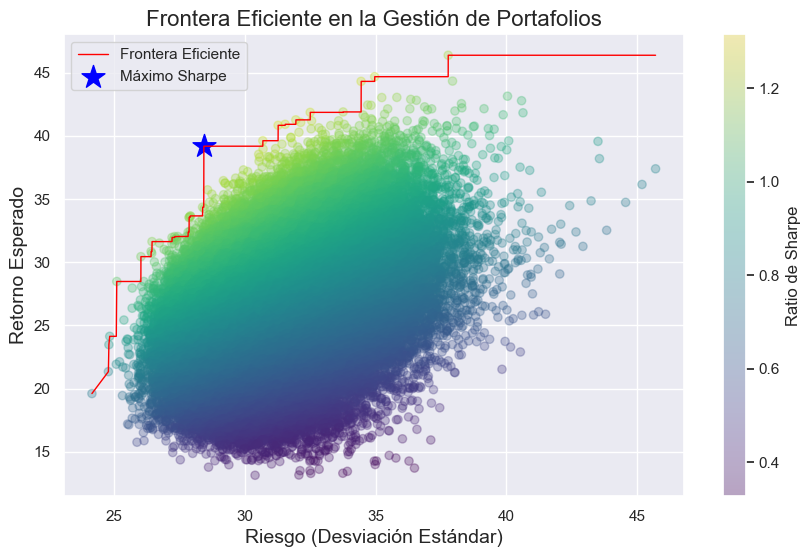

In [14]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_std = results[0, max_sharpe_idx]
max_sharpe_ret = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Ordenar portafolios por riesgo para calcular la frontera eficiente
sorted_indices = np.argsort(results[0])
sorted_risks = results[0, sorted_indices]
sorted_returns = results[1, sorted_indices]

# Calcular el máximo acumulado de retornos, que aproxima la frontera eficiente
efficient_returns = np.maximum.accumulate(sorted_returns)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sc = plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.3)
plt.plot(sorted_risks, efficient_returns, color='red', linewidth=1, label='Frontera Eficiente')
plt.scatter(max_sharpe_std, max_sharpe_ret, color='blue', marker='*', s=300, label='Máximo Sharpe')
plt.title('Frontera Eficiente en la Gestión de Portafolios', fontsize=16)
plt.xlabel('Riesgo (Desviación Estándar)', fontsize=14)
plt.ylabel('Retorno Esperado', fontsize=14)
plt.colorbar(sc, label='Ratio de Sharpe')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    mean_returns = mean_returns.apply(lambda x : (1 + x)**252 - 1)
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

In [16]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [17]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(12, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [18]:
returns = simple_retunrs
mean_returns = returns.mean()
cov_matrix = returns.cov()*252
num_portfolios = 250000
risk_free_rate = 0.0178

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.46
Annualised Volatility: 0.34


Ticker        UA  META   BAC  BABA    GME   NVDA  INTC    BA   AAPL     KO
allocation  1.04  4.16  3.91  2.31  13.29  36.27  0.27  0.14  27.18  11.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.25


Ticker        UA  META   BAC   BABA   GME  NVDA  INTC   BA  AAPL    KO
allocation  2.24  7.53  8.57  28.28  0.89  0.36  6.62  1.0  16.3  28.2


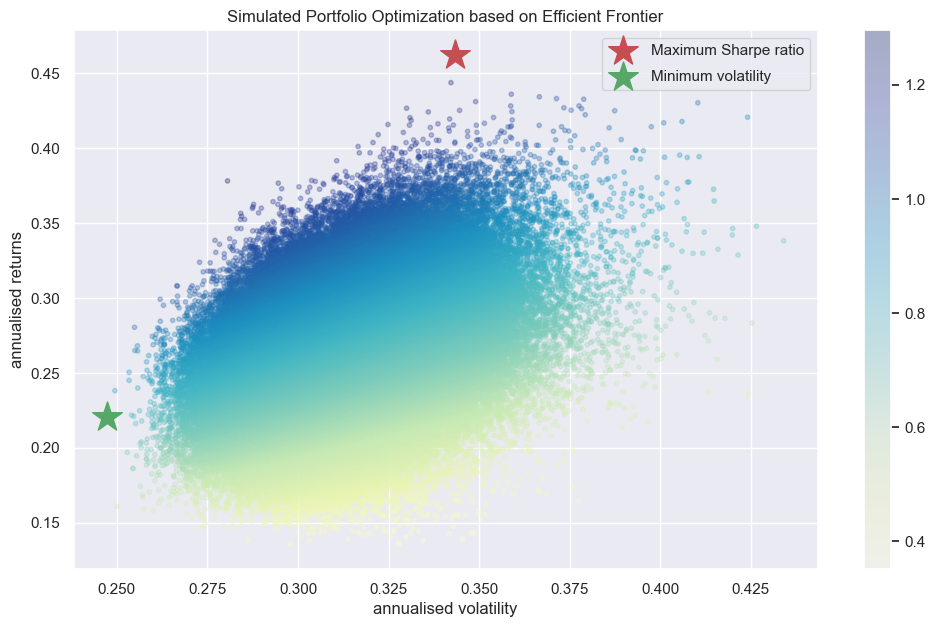

In [19]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [20]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for _ in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [21]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for _ in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [22]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for _ in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [23]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.8, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.57
Annualised Volatility: 0.35


Ticker       UA  META  BAC  BABA   GME  NVDA  INTC   BA   AAPL   KO
allocation  0.0   0.0  0.0   0.0  4.15  4.72   0.0  0.0  91.13  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.22


Ticker       UA  META  BAC   BABA   GME  NVDA  INTC   BA  AAPL     KO
allocation  0.0  9.18  0.0  20.37  0.54   0.0   0.0  0.0   0.0  69.91


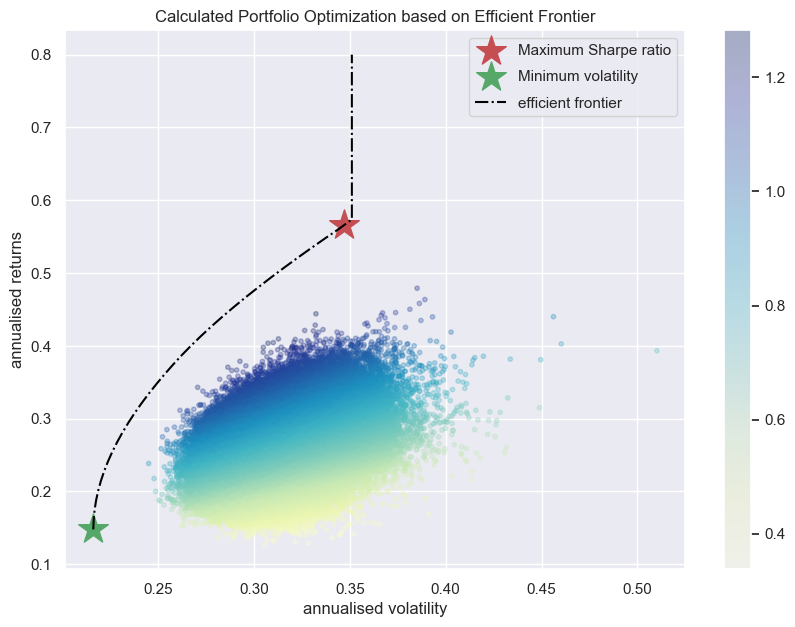

In [24]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [25]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(mean_returns.index):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.6, 500)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_24020\244077497.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
C:\Users\dfdop\AppData\Local\Temp\ipykernel_24020\244077497.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.57
Annualised Volatility: 0.35


Ticker       UA  META  BAC  BABA   GME  NVDA  INTC   BA   AAPL   KO
allocation  0.0   0.0  0.0   0.0  4.15  4.72   0.0  0.0  91.13  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.22


Ticker       UA  META  BAC   BABA   GME  NVDA  INTC   BA  AAPL     KO
allocation  0.0  9.18  0.0  20.37  0.54   0.0   0.0  0.0   0.0  69.91
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

UA : annuaised return 0.17 , annualised volatility: 0.54
META : annuaised return 0.21 , annualised volatility: 0.38
BAC : annuaised return 0.1 , annualised volatility: 0.39
BABA : annuaised return 0.14 , annualised volatility: 0.36
GME : annuaised 

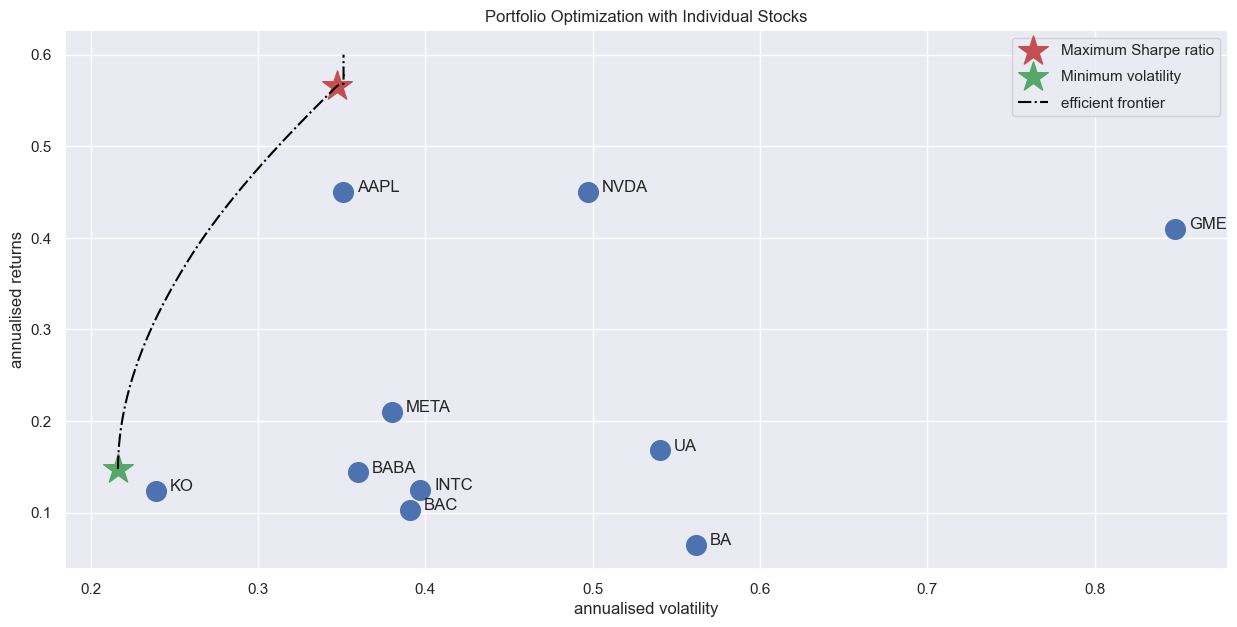

In [26]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

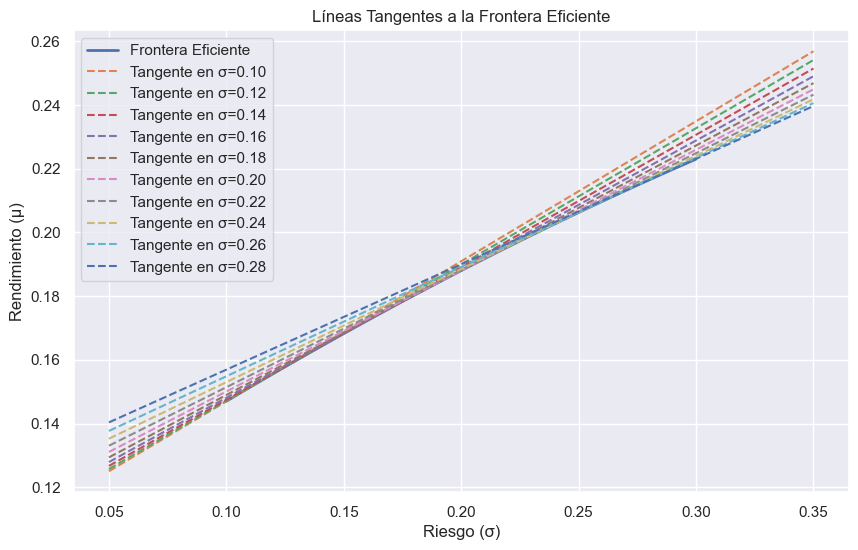

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo: Supongamos que la frontera eficiente se aproxima por:
# mu(σ) = 0.1 + 0.5*σ - 0.3*σ^2
# Donde σ representa el riesgo (desviación estándar) y μ el rendimiento esperado.

# Generamos un conjunto de valores para σ
sigma = np.linspace(0.1, 0.3, 100)
mu = 0.1 + 0.5 * sigma - 0.3 * sigma**2

# Calculamos la derivada numérica de μ respecto a σ usando np.gradient
dmu_dsigma = np.gradient(mu, sigma)

# Preparamos un rango para dibujar las líneas tangentes
x_vals = np.linspace(sigma.min() - 0.05, sigma.max() + 0.05, 200)

plt.figure(figsize=(10, 6))
plt.plot(sigma, mu, label='Frontera Eficiente', linewidth=2)

# Dibujamos la línea tangente en varios puntos de la frontera (por ejemplo, cada 10 puntos)
for i in range(0, len(sigma), 10):
    m = dmu_dsigma[i]         # Pendiente en el punto i
    x0 = sigma[i]
    y0 = mu[i]
    tangent_line = y0 + m * (x_vals - x0)
    plt.plot(x_vals, tangent_line, '--', label=f'Tangente en σ={x0:.2f}')

plt.xlabel('Riesgo (σ)')
plt.ylabel('Rendimiento (μ)')
plt.title('Líneas Tangentes a la Frontera Eficiente')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


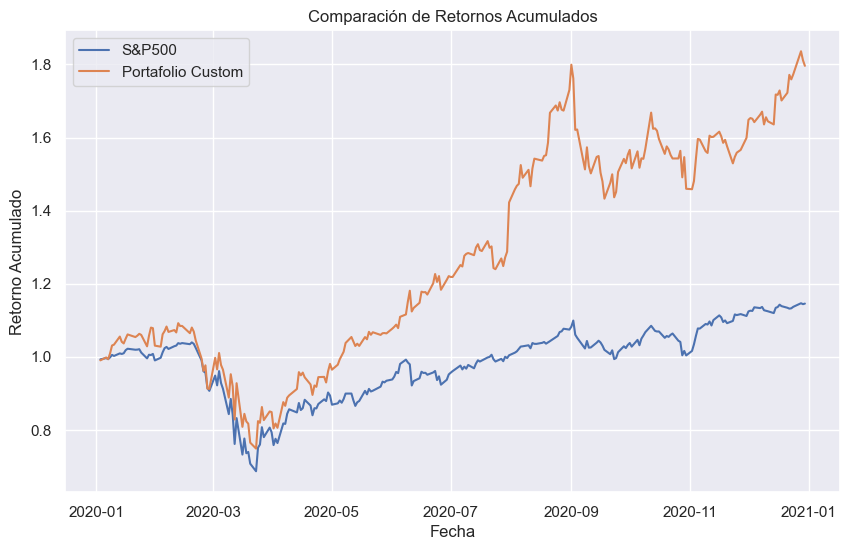

In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Definir el período de análisis
start_date = '2020-01-01'
end_date = '2020-12-31'

# Descargar datos del S&P500
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
sp500_data['Daily Return'] = sp500_data['Close'].pct_change()
sp500_data['Cumulative Return'] = (1 + sp500_data['Daily Return']).cumprod()

# Supongamos que tu portafolio custom está compuesto por uno o varios activos.
# Aquí se ejemplifica con el ticker de AAPL. Si tu portafolio es una combinación de activos,
# deberías calcular el retorno ponderado diario.
portfolio_ticker = 'AAPL'
portfolio_data = yf.download(portfolio_ticker, start=start_date, end=end_date)
portfolio_data['Daily Return'] = portfolio_data['Close'].pct_change()
portfolio_data['Cumulative Return'] = (1 + portfolio_data['Daily Return']).cumprod()

# Graficar la comparación
plt.figure(figsize=(10,6))
plt.plot(sp500_data.index, sp500_data['Cumulative Return'], label='S&P500')
plt.plot(portfolio_data.index, portfolio_data['Cumulative Return'], label='Portafolio Custom')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.title('Comparación de Retornos Acumulados')
plt.legend()
plt.show()


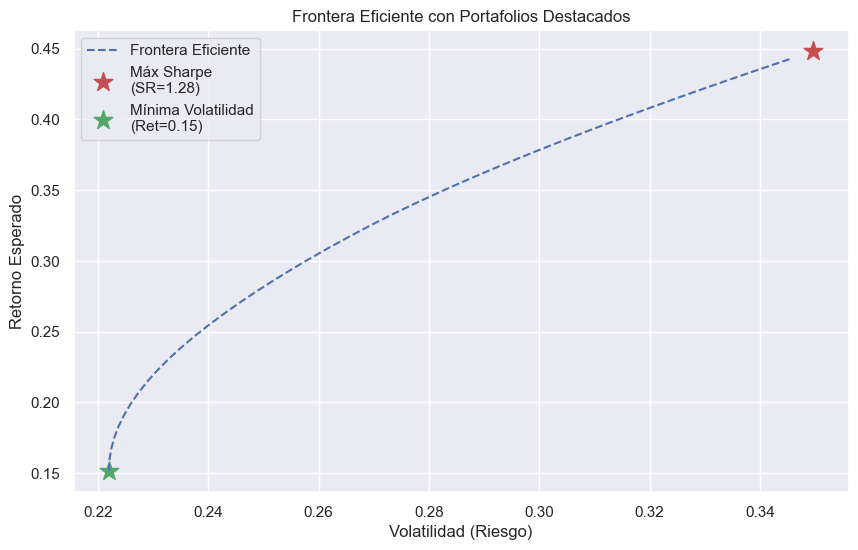

In [48]:
# Calcular los retornos esperados anuales y la matriz de covarianza a partir de los precios históricos
mu = expected_returns.mean_historical_return(close_prices, compounding=False)
S = risk_models.CovarianceShrinkage(close_prices).ledoit_wolf()

# 3. Cálculo de la frontera eficiente para distintos retornos objetivo
# Definimos un rango de retornos objetivo (dentro del rango factible)
target_returns = np.linspace(mu.min(), mu.max(), 50)
volatilities = []
returns_list = []

for target_return in target_returns:
    # Para evitar contaminación entre iteraciones, se crea una nueva instancia de EfficientFrontier
    ef_temp = EfficientFrontier(mu, S)
    try:
        ef_temp.efficient_return(target_return)
        performance = ef_temp.portfolio_performance(verbose=False)
        ret, vol, sr = performance  # sr es el ratio de Sharpe
        returns_list.append(ret)
        volatilities.append(vol)
    except Exception as e:
        returns_list.append(np.nan)
        volatilities.append(np.nan)

# 4. Cálculo del portafolio de máximo Sharpe
ef_max = EfficientFrontier(mu, S)
weights_max = ef_max.max_sharpe()
ret_max, vol_max, sr_max = ef_max.portfolio_performance(verbose=False)

# 5. Cálculo del portafolio de mínima volatilidad
ef_min = EfficientFrontier(mu, S)
weights_min = ef_min.min_volatility()
ret_min, vol_min, sr_min = ef_min.portfolio_performance(verbose=False)

# 6. Graficar la frontera eficiente y los portafolios destacados
plt.figure(figsize=(10, 6))
plt.plot(volatilities, returns_list, "b--", label="Frontera Eficiente")
plt.scatter(vol_max, ret_max, marker="*", color="r", s=200, label=f"Máx Sharpe\n(SR={sr_max:.2f})")
plt.scatter(vol_min, ret_min, marker="*", color="g", s=200, label=f"Mínima Volatilidad\n(Ret={ret_min:.2f})")
plt.xlabel("Volatilidad (Riesgo)")
plt.ylabel("Retorno Esperado")
plt.title("Frontera Eficiente con Portafolios Destacados")
plt.legend()
plt.grid(True)
plt.show()



In [49]:
returns_risk = pd.DataFrame(mu, columns=['return'])
returns_risk['risk'] = np.diag(S)

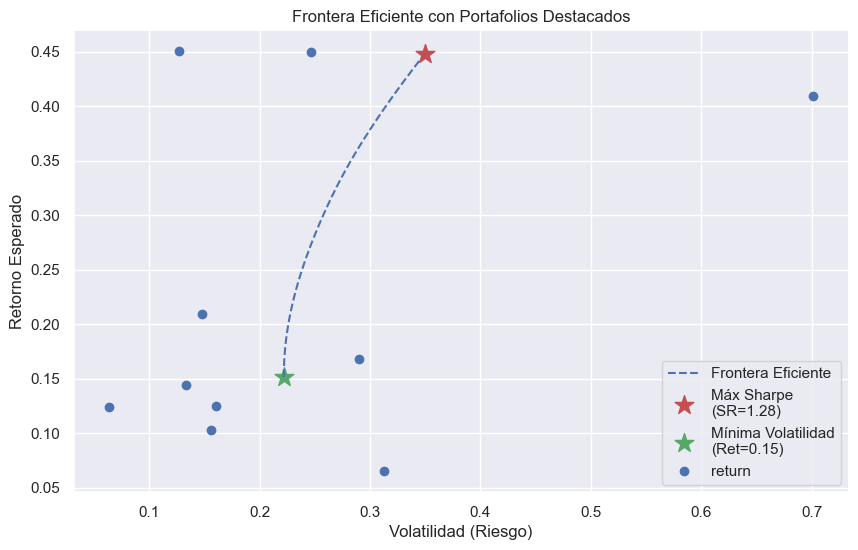

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(volatilities, returns_list, "b--", label="Frontera Eficiente")
plt.scatter(vol_max, ret_max, marker="*", color="r", s=200, label=f"Máx Sharpe\n(SR={sr_max:.2f})")
plt.scatter(vol_min, ret_min, marker="*", color="g", s=200, label=f"Mínima Volatilidad\n(Ret={ret_min:.2f})")
plt.scatter(data= returns_risk, x = 'risk', y = 'return')
plt.xlabel("Volatilidad (Riesgo)")
plt.ylabel("Retorno Esperado")
plt.title("Frontera Eficiente con Portafolios Destacados")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import riskfolio as rp
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 1. Definir la lista de activos
tickers = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']

# 2. Descargar datos históricos (precio ajustado)
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Close']

# 3. Calcular los rendimientos diarios y eliminar valores nulos
returns = data.pct_change().dropna()

[*********************100%***********************]  25 of 25 completed


In [24]:
port = rp.Portfolio(returns=returns)

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)   

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.08059,5.160342e-12,7.288088e-12,5.234579e-11,9.817683e-12,1.635298e-11,0.216017,0.40965,1.935829e-11,5.838535e-11,...,1.753924e-11,2.322957e-11,0.04245,3.406791e-11,9.478348e-12,3.039346e-11,0.251292,1.899722e-11,1.043795e-11,1.060722e-11


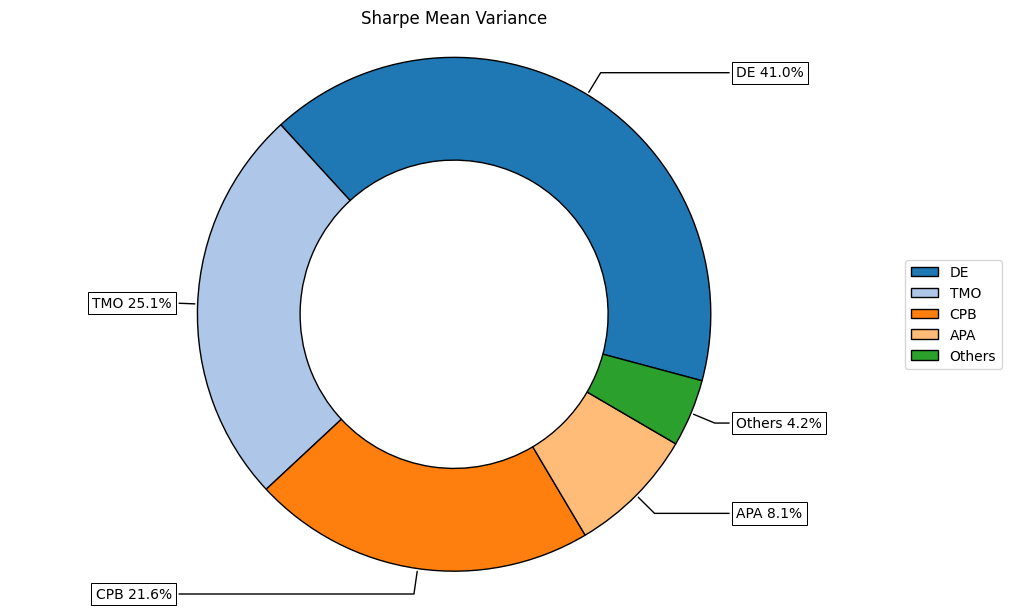

In [25]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [26]:
points = 100 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,2.165189e-09,1.623852e-09,2.594263e-08,0.248776,2.654492e-08,2.029452e-09,0.182431,9.658000e-09,4.630150e-09,1.185096e-08,...,3.076240e-09,6.873068e-02,0.039485,7.262066e-08,4.458174e-09,1.206754e-02,0.056286,1.336371e-09,3.623643e-01,4.054172e-09
1,3.278113e-03,3.162831e-10,8.294939e-10,0.240646,2.068920e-09,6.408459e-10,0.249175,8.470165e-02,1.772119e-09,6.195356e-08,...,9.767417e-10,3.569696e-02,0.079565,1.261997e-02,1.067858e-09,6.496188e-03,0.108209,5.511181e-10,1.452720e-01,1.360408e-09
2,9.914159e-03,3.631982e-10,8.749136e-10,0.235583,1.739101e-09,7.643985e-10,0.282182,1.259840e-01,1.701728e-09,5.676769e-08,...,1.114740e-09,1.286760e-02,0.095945,1.540709e-02,1.214752e-09,3.094862e-03,0.129220,6.653059e-10,5.545295e-02,1.262441e-09
3,1.736757e-02,3.145127e-11,6.269546e-11,0.222138,1.204774e-10,8.414936e-11,0.305391,1.645660e-01,1.612402e-10,9.537576e-10,...,1.255449e-10,9.940803e-10,0.108559,1.385899e-02,1.001048e-10,9.987694e-10,0.148635,8.437734e-11,3.356873e-10,1.142690e-10
4,2.878353e-02,4.338001e-11,7.750589e-11,0.168032,1.311526e-10,1.272892e-10,0.304594,2.112556e-01,2.139193e-10,2.191937e-09,...,1.723294e-10,5.112814e-10,0.111321,8.465448e-09,1.149399e-10,7.266087e-10,0.175708,1.268336e-10,2.008514e-10,1.311548e-10


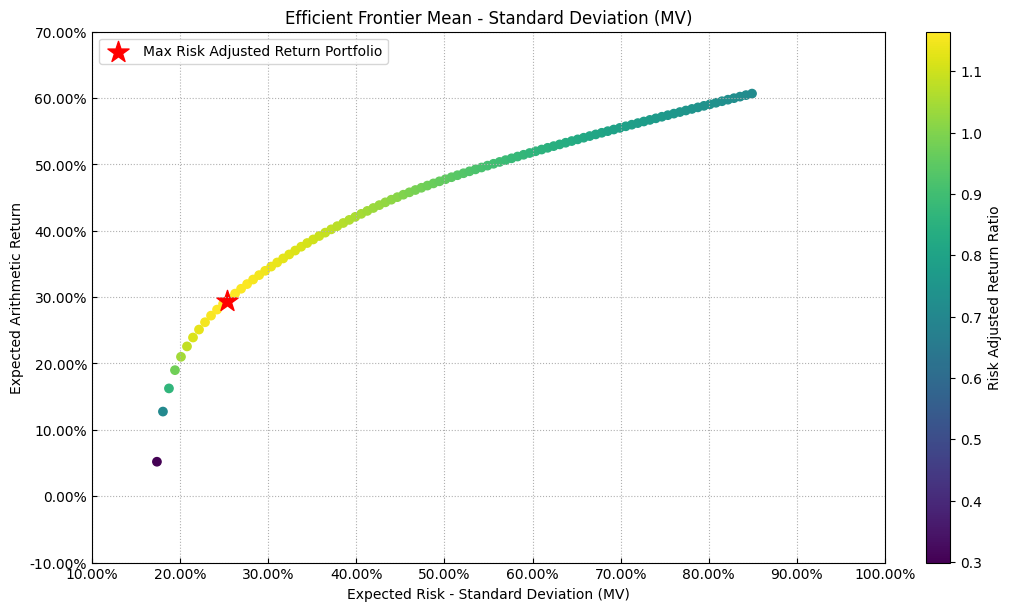

In [27]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

[*********************100%***********************]  5 of 5 completed


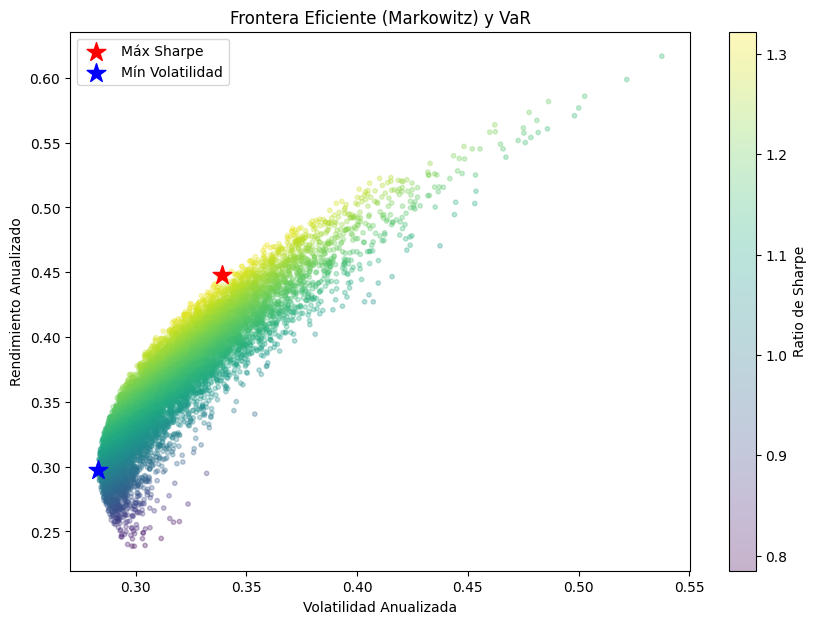

Portafolio con el Mejor Ratio de Sharpe:
Rendimiento Anualizado: 0.44825651070819034
Volatilidad Anualizada: 0.3390795883038166
Ratio de Sharpe: 1.321980225794514
VaR (95%): 0.11122480999310708
Pesos:
AAPL     0.486687
MSFT     0.000247
GOOGL    0.030002
AMZN     0.219752
TSLA     0.263313
Name: 2433, dtype: float64

Portafolio con Mínima Volatilidad:
Rendimiento Anualizado: 0.2973744919787677
Volatilidad Anualizada: 0.2831262647646276
Ratio de Sharpe: 1.0503246395242953
VaR (95%): 0.1697838448828678
Pesos:
AAPL     0.246482
MSFT     0.125357
GOOGL    0.303736
AMZN     0.322611
TSLA     0.001815
Name: 7127, dtype: float64


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lista de tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

# Descargar datos históricos ajustados (desde 2019 hasta 2024)
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")["Close"]

# Calcular rendimientos diarios y eliminar valores nulos
returns = data.pct_change().dropna()

# Calcular rendimientos esperados y matriz de covarianza anualizados
annual_returns = returns.mean() * 252
annual_cov = returns.cov() * 252

# Número de portafolios a simular
num_portfolios = 10000

# Arreglos para almacenar los resultados:
# Índices: 0 -> Rendimiento, 1 -> Volatilidad, 2 -> Ratio de Sharpe, 3 -> VaR (95%)
results = np.zeros((4, num_portfolios))
weights_record = []

# Nivel de confianza para el VaR (por ejemplo, 95%); z para distribución normal ≈ 1.65
z = 1.65

# Simulación de portafolios
for i in range(num_portfolios):
    # Generar pesos aleatorios y normalizarlos para que sumen 1
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    # Calcular rendimiento esperado de la cartera
    port_return = np.dot(weights, annual_returns)
    # Calcular volatilidad de la cartera
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    # Suponiendo tasa libre de riesgo = 0, el ratio de Sharpe es:
    sharpe_ratio = port_return / port_volatility
    
    # Calcular VaR asumiendo distribución normal:
    # VaR = -(rendimiento - z * volatilidad)
    portfolio_var = -(port_return - z * port_volatility)
    
    # Almacenar resultados
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio
    results[3, i] = portfolio_var

# Convertir resultados a DataFrame para un análisis más cómodo
results_df = pd.DataFrame(results.T, columns=["Return", "Volatility", "Sharpe", "VaR"])
weights_df = pd.DataFrame(weights_record, columns=tickers)

# Identificar el portafolio con el máximo Ratio de Sharpe y el de mínima volatilidad
max_sharpe_idx = results_df["Sharpe"].idxmax()
max_sharpe_port = results_df.loc[max_sharpe_idx]
max_sharpe_weights = weights_df.loc[max_sharpe_idx]

min_vol_idx = results_df["Volatility"].idxmin()
min_vol_port = results_df.loc[min_vol_idx]
min_vol_weights = weights_df.loc[min_vol_idx]

# Graficar la Frontera Eficiente
plt.figure(figsize=(10, 7))
sc = plt.scatter(results_df["Volatility"], results_df["Return"], c=results_df["Sharpe"], cmap="viridis", s=10, alpha=0.3)
plt.colorbar(sc, label="Ratio de Sharpe")
plt.scatter(max_sharpe_port["Volatility"], max_sharpe_port["Return"], color="red", marker="*", s=200, label="Máx Sharpe")
plt.scatter(min_vol_port["Volatility"], min_vol_port["Return"], color="blue", marker="*", s=200, label="Mín Volatilidad")
plt.title("Frontera Eficiente (Markowitz) y VaR")
plt.xlabel("Volatilidad Anualizada")
plt.ylabel("Rendimiento Anualizado")
plt.legend()
plt.show()

# Mostrar resultados
print("Portafolio con el Mejor Ratio de Sharpe:")
print("Rendimiento Anualizado:", max_sharpe_port["Return"])
print("Volatilidad Anualizada:", max_sharpe_port["Volatility"])
print("Ratio de Sharpe:", max_sharpe_port["Sharpe"])
print("VaR (95%):", max_sharpe_port["VaR"])
print("Pesos:")
print(max_sharpe_weights)

print("\nPortafolio con Mínima Volatilidad:")
print("Rendimiento Anualizado:", min_vol_port["Return"])
print("Volatilidad Anualizada:", min_vol_port["Volatility"])
print("Ratio de Sharpe:", min_vol_port["Sharpe"])
print("VaR (95%):", min_vol_port["VaR"])
print("Pesos:")
print(min_vol_weights)


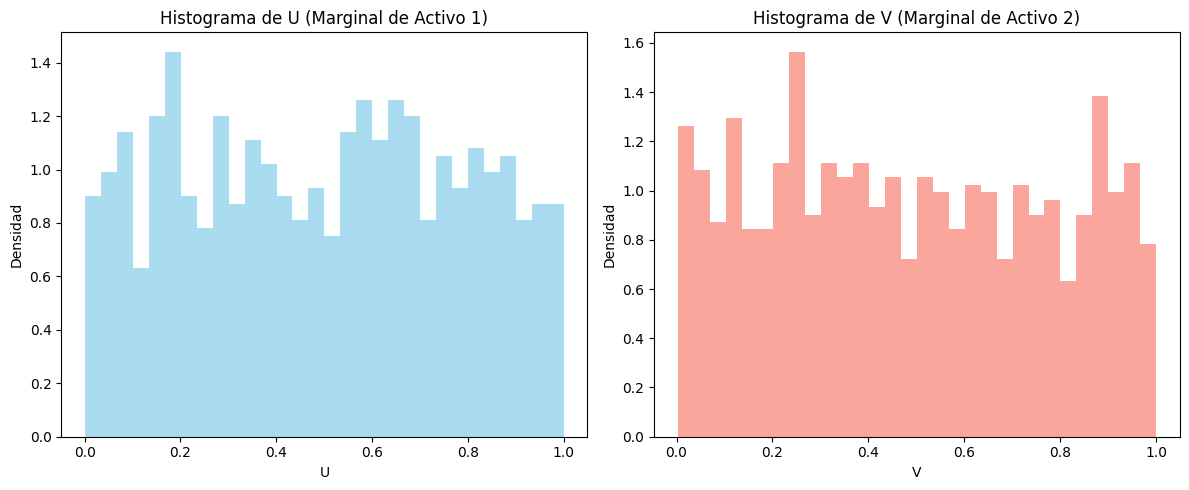

Theta estimado de la Cópula de Clayton: 0.3674913932525668
VaR al 95% (Copula de Clayton): 0.017674039474116096


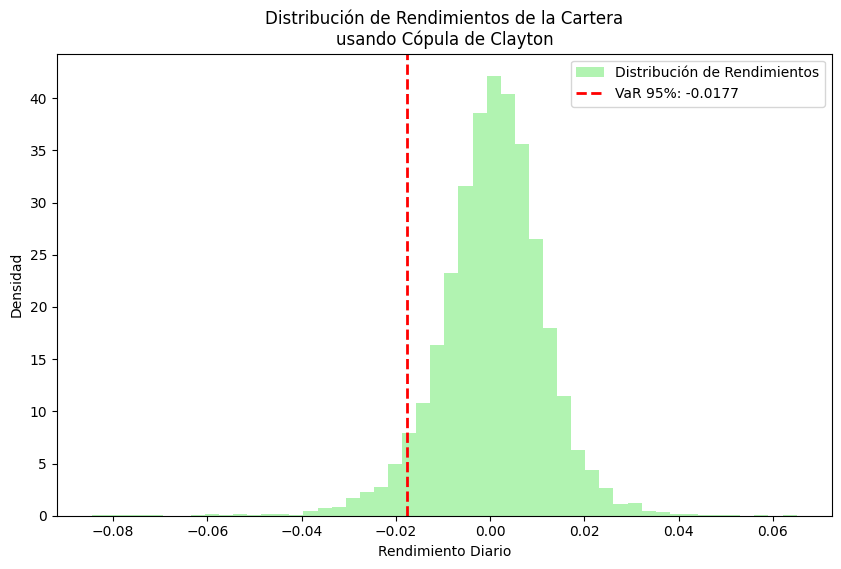

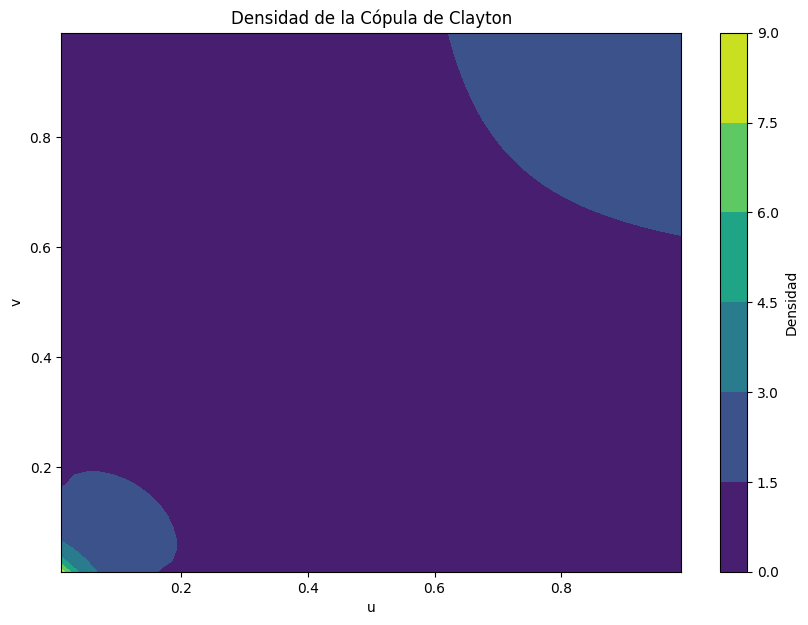

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, uniform
from scipy.optimize import minimize

# Función de la Cópula de Clayton
def clayton_copula(u, v, theta):
    # u y v son arrays de probabilidades (valores marginales transformados)
    return (u**(-theta) + v**(-theta) - 1) ** (-1/theta)

# Función de densidad de la Cópula de Clayton
def clayton_copula_pdf(u, v, theta):
    term1 = (theta + 1) * (u * v) ** (-theta - 1)
    term2 = (u**(-theta) + v**(-theta) - 1) ** (-1/theta - 2)
    term3 = 1 + theta * (u**(-theta) + v**(-theta) - 1) ** (-1)
    return term1 * term2 * term3

# Simulación de datos marginales: supongamos que ambos activos tienen distribución t-Student
# Definimos parámetros para las distribuciones marginales
df1, df2 = 5, 5  # grados de libertad
loc1, loc2 = 0.0005, 0.0003  # medias diarias
scale1, scale2 = 0.01, 0.012  # escalas (desviaciones)

n_samples = 1000
np.random.seed(42)
# Simular rendimientos diarios
r1 = t.rvs(df=df1, loc=loc1, scale=scale1, size=n_samples)
r2 = t.rvs(df=df2, loc=loc2, scale=scale2, size=n_samples)

# Transformar a uniformes (usando la función de distribución acumulada, CDF)
u = t.cdf(r1, df=df1, loc=loc1, scale=scale1)
v = t.cdf(r2, df=df2, loc=loc2, scale=scale2)

# Graficar histograma de las variables marginales (transformadas a uniforme)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(u, bins=30, density=True, alpha=0.7, color='skyblue')
plt.title("Histograma de U (Marginal de Activo 1)")
plt.xlabel("U")
plt.ylabel("Densidad")

plt.subplot(1,2,2)
plt.hist(v, bins=30, density=True, alpha=0.7, color='salmon')
plt.title("Histograma de V (Marginal de Activo 2)")
plt.xlabel("V")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

# Estimación del parámetro theta de la Cópula de Clayton
# Usaremos la máxima verosimilitud. Aquí definimos la función de verosimilitud negativa:
def neg_log_likelihood(theta, u, v):
    if theta <= 0:
        return np.inf
    pdf_vals = clayton_copula_pdf(u, v, theta)
    # Evitar log(0) o valores negativos
    pdf_vals = np.where(pdf_vals<=0, 1e-10, pdf_vals)
    return -np.sum(np.log(pdf_vals))

res = minimize(neg_log_likelihood, x0=np.array([1.0]), args=(u, v), bounds=[(0.001, None)])
theta_est = res.x[0]
print("Theta estimado de la Cópula de Clayton:", theta_est)

# Ahora, construyamos una cartera de dos activos usando pesos dados (por ejemplo, 50% cada uno)
weights = np.array([0.5, 0.5])

# Para calcular el VaR de la cartera, se puede simular la dependencia mediante la copula.
# Primero, simulemos parejas de valores (u, v) de la copula de Clayton:
n_sim = 10000
# Método de muestreo inverso (no trivial para copulas), usaremos un método de aproximación:
# Aquí, para simplificar, usaremos la inversa de la función condicional de la copula:
# Para la Cópula de Clayton, la función condicional de V dado U=u es:
# F(v|u) = 1 - [ u^(-theta) * (1 - v^(-theta)) + 1 ]^(-1/theta)
# Sin embargo, en la práctica, se puede generar muestras de (u,v) mediante técnicas de aceptación-rechazo.
# Por simplicidad, utilizaremos la siguiente simulación basada en la relación de dependencia:
def simulate_clayton(theta, n):
    # Generar u uniformemente
    u = uniform.rvs(size=n)
    # Generar v condicionalmente: v = [1 + u^(-theta) * ((w)**(-theta/(theta+1)) - 1)]^(-1/theta)
    # donde w es otra variable uniforme
    w = uniform.rvs(size=n)
    v = (1 + u**(-theta) * (w**(-theta/(theta+1)) - 1))**(-1/theta)
    return u, v

u_sim, v_sim = simulate_clayton(theta_est, n_sim)

# Convertir las muestras simuladas a rendimientos utilizando la función inversa de la CDF t
r1_sim = t.ppf(u_sim, df=df1, loc=loc1, scale=scale1)
r2_sim = t.ppf(v_sim, df=df2, loc=loc2, scale=scale2)

# Calcular el rendimiento diario de la cartera simulada:
portfolio_returns = weights[0] * r1_sim + weights[1] * r2_sim

# Calcular el VaR al 95%: buscamos el percentil 5% de la distribución de pérdidas
# VaR = -percentil(5) (suponiendo que las pérdidas son negativas)
VaR_95 = -np.percentile(portfolio_returns, 5)
print("VaR al 95% (Copula de Clayton):", VaR_95)

# Graficar la distribución de los rendimientos de la cartera y marcar el VaR
plt.figure(figsize=(10,6))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.7, color='lightgreen', label="Distribución de Rendimientos")
plt.axvline(-VaR_95, color='red', linestyle='--', linewidth=2, label=f"VaR 95%: {-VaR_95:.4f}")
plt.title("Distribución de Rendimientos de la Cartera\nusando Cópula de Clayton")
plt.xlabel("Rendimiento Diario")
plt.ylabel("Densidad")
plt.legend()
plt.show()

# Graficar la superficie de la Cópula de Clayton
# Crear una malla para u y v
u_vals = np.linspace(0.01, 0.99, 50)
v_vals = np.linspace(0.01, 0.99, 50)
U, V = np.meshgrid(u_vals, v_vals)
C_pdf = clayton_copula_pdf(U, V, theta_est)

plt.figure(figsize=(10, 7))
cp = plt.contourf(U, V, C_pdf, cmap="viridis")
plt.title("Densidad de la Cópula de Clayton")
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar(cp, label="Densidad")
plt.show()


[*********************100%***********************]  2 of 2 completed


Parámetro estimado de la Cópula de Clayton: 350838.7777839374
VaR (95%): 0.08871091924878245


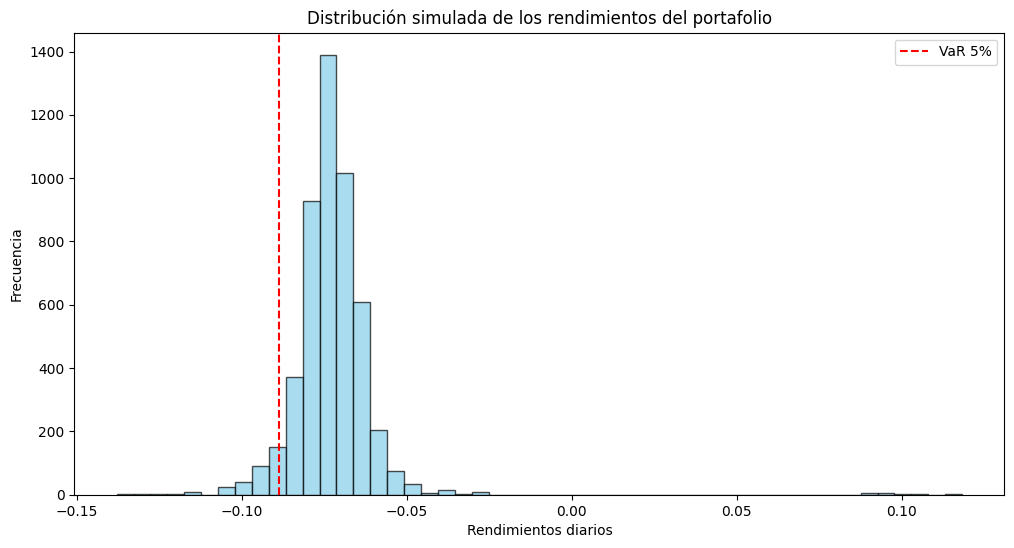

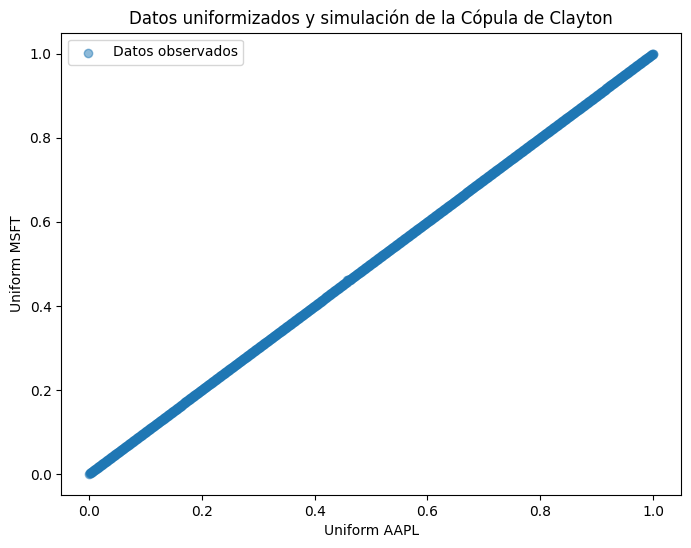

In [6]:
# Instalar la librería copulae (si aún no está instalada)
# !pip install copulae

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import ClaytonCopula

# -------------------------------
# Paso 1: Descarga de datos y cálculo de rendimientos
# -------------------------------
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Close']
returns = data.pct_change().dropna()  # rendimientos diarios

# -------------------------------
# Paso 2: Transformar los rendimientos a márgenes uniformes usando la función ECDF
# -------------------------------
def to_uniform(series):
    ecdf = ECDF(series)
    return ecdf(series)

u_AAPL = to_uniform(returns['AAPL'])
u_MSFT = to_uniform(returns['MSFT'])

# Combinar en un array de forma (n, 2)
u_data = np.column_stack([u_AAPL, u_MSFT])

# -------------------------------
# Paso 3: Ajustar una Cópula de Clayton a los datos uniformes
# -------------------------------
clayton = ClaytonCopula(dim=2)
clayton.fit(u_data)
print("Parámetro estimado de la Cópula de Clayton:", clayton.params)

# -------------------------------
# Paso 4: Simulación de nuevos datos a partir de la Cópula
# -------------------------------
n_sim = 5000
u_sim = clayton.random(n_sim)

# -------------------------------
# Paso 5: Invertir los márgenes: utilizar la función de cuantiles empírica
# -------------------------------
def inverse_empirical(series, u):
    # Para cada valor u (entre 0 y 1), obtenemos el percentil correspondiente
    return np.percentile(series, u * 100)

sim_AAPL = np.array([inverse_empirical(returns['AAPL'], u) for u in u_sim[:, 0]])
sim_MSFT = np.array([inverse_empirical(returns['MSFT'], u) for u in u_sim[:, 1]])

# -------------------------------
# Paso 6: Calcular los rendimientos del portafolio
# Supongamos un portafolio equitativo (50% AAPL y 50% MSFT)
# -------------------------------
weights = np.array([0.5, 0.5])
sim_portfolio_returns = weights[0] * sim_AAPL + weights[1] * sim_MSFT

# -------------------------------
# Paso 7: Calcular el VaR (al 95% – es decir, el percentil 5) asumiendo distribución normal en la cola
# (Se expresa el VaR como un valor positivo que representa la pérdida potencial)
# -------------------------------
VaR_5 = -np.percentile(sim_portfolio_returns, 5)
print("VaR (95%):", VaR_5)

# -------------------------------
# Paso 8: Gráficas
# 1. Histograma de los rendimientos simulados del portafolio y línea que marca el VaR
# 2. Dispersión de los datos uniformizados (observados) para visualizar la dependencia modelada por la copula
# -------------------------------

plt.figure(figsize=(12,6))
plt.hist(sim_portfolio_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(sim_portfolio_returns, 5), color='red', linestyle='--', label='VaR 5%')
plt.title("Distribución simulada de los rendimientos del portafolio")
plt.xlabel("Rendimientos diarios")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(u_data[:,0], u_data[:,1], alpha=0.5, label="Datos observados")
plt.title("Datos uniformizados y simulación de la Cópula de Clayton")
plt.xlabel("Uniform AAPL")
plt.ylabel("Uniform MSFT")
plt.legend()
plt.show()


[*********************100%***********************]  2 of 2 completed


Parámetro estimado de la Cópula de Clayton: 350838.7777839374
VaR (95%): 0.08895669168527207


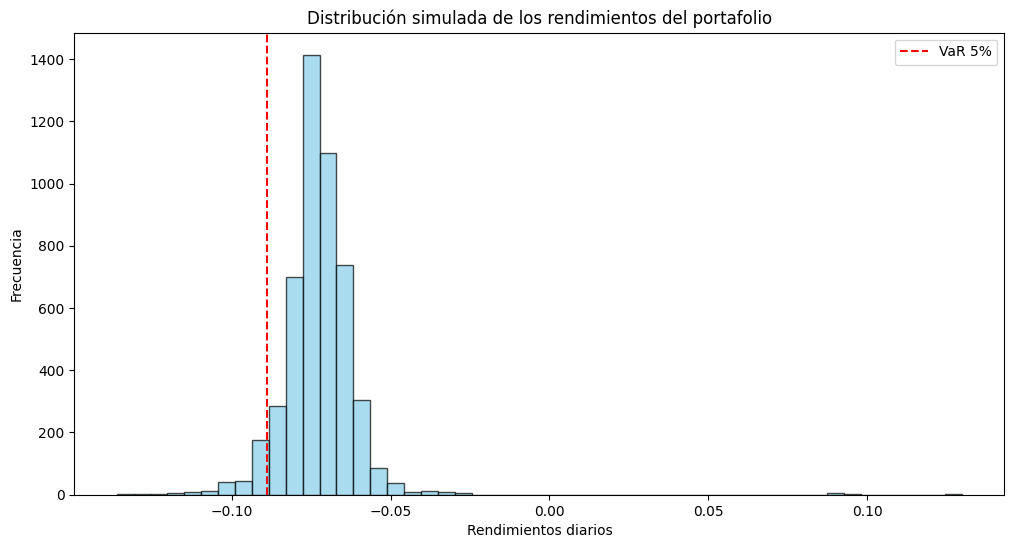

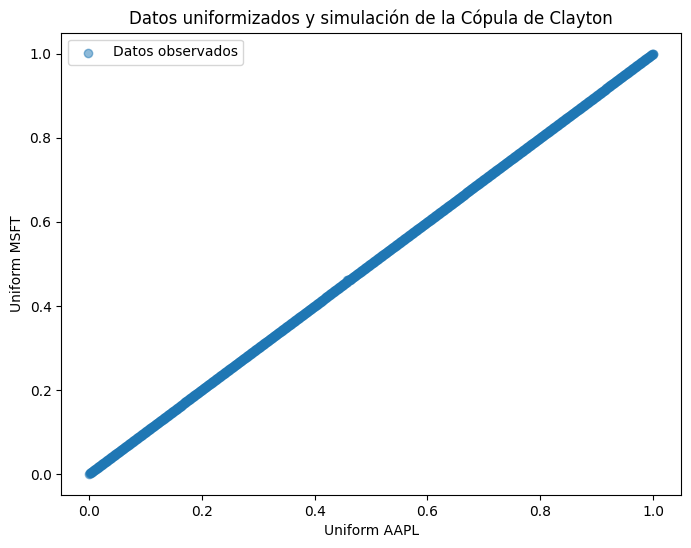

In [7]:
# Instalar la librería copulae (si aún no está instalada)
# !pip install copulae

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import ClaytonCopula

# -------------------------------
# Paso 1: Descarga de datos y cálculo de rendimientos
# -------------------------------
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Close']
returns = data.pct_change().dropna()  # rendimientos diarios

# -------------------------------
# Paso 2: Transformar los rendimientos a márgenes uniformes usando la función ECDF
# -------------------------------
def to_uniform(series):
    ecdf = ECDF(series)
    return ecdf(series)

u_AAPL = to_uniform(returns['AAPL'])
u_MSFT = to_uniform(returns['MSFT'])

# Combinar en un array de forma (n, 2)
u_data = np.column_stack([u_AAPL, u_MSFT])

# -------------------------------
# Paso 3: Ajustar una Cópula de Clayton a los datos uniformes
# -------------------------------
clayton = ClaytonCopula(dim=2)
clayton.fit(u_data)
print("Parámetro estimado de la Cópula de Clayton:", clayton.params)

# -------------------------------
# Paso 4: Simulación de nuevos datos a partir de la Cópula
# -------------------------------
n_sim = 5000
u_sim = clayton.random(n_sim)

# -------------------------------
# Paso 5: Invertir los márgenes: utilizar la función de cuantiles empírica
# -------------------------------
def inverse_empirical(series, u):
    # Para cada valor u (entre 0 y 1), obtenemos el percentil correspondiente
    return np.percentile(series, u * 100)

sim_AAPL = np.array([inverse_empirical(returns['AAPL'], u) for u in u_sim[:, 0]])
sim_MSFT = np.array([inverse_empirical(returns['MSFT'], u) for u in u_sim[:, 1]])

# -------------------------------
# Paso 6: Calcular los rendimientos del portafolio
# Supongamos un portafolio equitativo (50% AAPL y 50% MSFT)
# -------------------------------
weights = np.array([0.5, 0.5])
sim_portfolio_returns = weights[0] * sim_AAPL + weights[1] * sim_MSFT

# -------------------------------
# Paso 7: Calcular el VaR (al 95% – es decir, el percentil 5) asumiendo distribución normal en la cola
# (Se expresa el VaR como un valor positivo que representa la pérdida potencial)
# -------------------------------
VaR_5 = -np.percentile(sim_portfolio_returns, 5)
print("VaR (95%):", VaR_5)

# -------------------------------
# Paso 8: Gráficas
# 1. Histograma de los rendimientos simulados del portafolio y línea que marca el VaR
# 2. Dispersión de los datos uniformizados (observados) para visualizar la dependencia modelada por la copula
# -------------------------------

plt.figure(figsize=(12,6))
plt.hist(sim_portfolio_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(sim_portfolio_returns, 5), color='red', linestyle='--', label='VaR 5%')
plt.title("Distribución simulada de los rendimientos del portafolio")
plt.xlabel("Rendimientos diarios")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(u_data[:,0], u_data[:,1], alpha=0.5, label="Datos observados")
plt.title("Datos uniformizados y simulación de la Cópula de Clayton")
plt.xlabel("Uniform AAPL")
plt.ylabel("Uniform MSFT")
plt.legend()
plt.show()


In [1]:
import yfinance as yf
import pandas as pd


In [2]:
tickers = ['^GSPC', 'NU']

In [3]:
nu_df = yf.download( tickers,
                      start = '2020-01-01',
                      end = '2025-01-01',
                      group_by = 'tiker',
                      threads = True
    
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [4]:
nu_aux = nu_df.xs('Close', axis=1, level=1)

In [5]:
nu_aux = nu_aux.dropna()

In [6]:
nu_aux.rename(columns={'^GSPC': 'S&P-500'}, inplace=True)

In [11]:
nu_aux = nu_aux[nu_aux.index >= '2024-04-01']

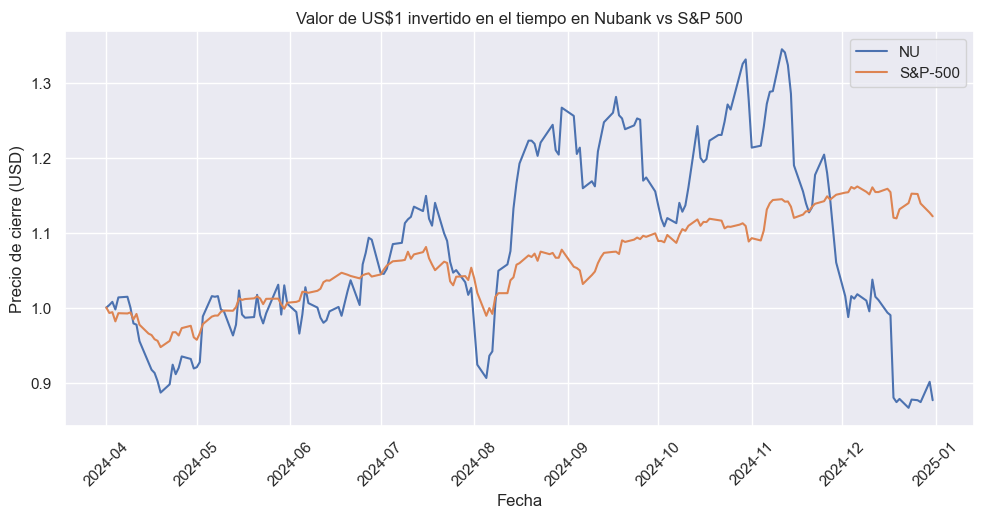

In [15]:
normalize_prices = nu_aux.div(nu_aux.iloc[0])
plt.figure(figsize=(10, 5))
plt.plot(normalize_prices, label = ['NU', 'S&P-500'])
plt.title("Valor de US$1 invertido en el tiempo en Nubank vs S&P 500")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("nubank_precio_accion.png", dpi=300, bbox_inches='tight')
plt.show()

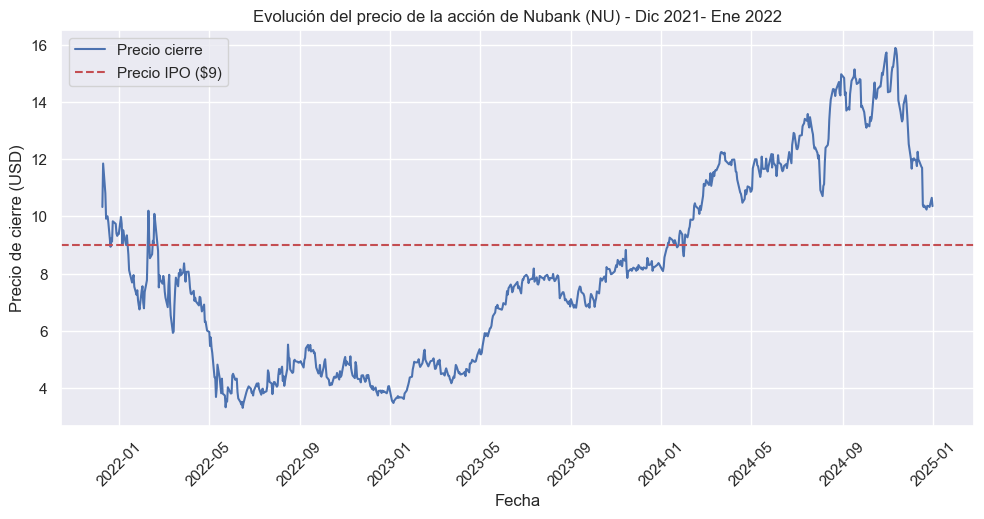

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos aproximados extraídos de fuentes como Macrotrends, Yahoo Finance, y artículos financieros
# sobre el precio de la acción NU (Nu Holdings) desde su IPO

# Evolución mensual del precio de cierre de NU desde diciembre 2021 a diciembre 2022
data = {
    "Fecha": [
        "2021-12", "2022-01", "2022-02", "2022-03", "2022-04", "2022-05",
        "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12"
    ],
    "Precio_Cierre_USD": [
        9.90, 8.25, 7.00, 6.50, 5.00, 3.50, 3.70, 4.00, 4.25, 4.10, 4.20, 4.00, 4.07
    ]
}

df_precio = pd.DataFrame(data)
df_precio["Fecha"] = pd.to_datetime(df_precio["Fecha"])

# Gráfico de evolución del precio de la acción
plt.figure(figsize=(10, 5))
plt.plot(nu_aux.index, nu_aux['NU'], label="Precio cierre")
plt.axhline(y=9.00, color='r', linestyle='--', label="Precio IPO ($9)")
plt.title("Evolución del precio de la acción de Nubank (NU) - Dic 2021- Ene 2022")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("nubank_precio_accion.png", dpi=300, bbox_inches='tight')
plt.show()

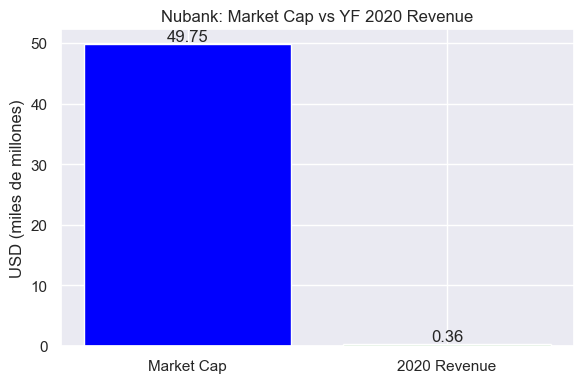

In [83]:
import yfinance as yf
import matplotlib.pyplot as plt

# 1. Definir el ticker de Nubank
ticker = "NU"
nu = yf.Ticker(ticker)

# 2. Obtener la capitalización de mercado desde info
market_cap = nu.info.get('marketCap', None)
if market_cap is not None:
    # Convertir a miles de millones (USD)
    market_cap_b = market_cap / 1e9
else:
    market_cap_b = 0

# 3. Obtener los estados financieros anuales
financials = nu.financials

# Inicializamos revenue_2020
revenue_2020 = None

# Buscar la columna correspondiente al año 2020
for col in financials.columns:
    # Las columnas son de tipo Timestamp, se extrae el año
    if col.year == 2020:
        if "Total Revenue" in financials.index:
            revenue_2020 = financials.loc["Total Revenue", col]
        break

if revenue_2020 is not None:
    # Convertir a miles de millones (USD)
    revenue_2020_b = revenue_2020 / 1e9
else:
    revenue_2020_b = 0

# 4. Crear la gráfica de barras con ambos valores
labels = ['Market Cap', '2020 Revenue']
values = [market_cap_b, revenue_2020_b]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=['blue', 'green'])
plt.ylabel("USD (miles de millones)")
plt.title("Nubank: Market Cap vs YF 2020 Revenue")

# Añadir etiqueta con el valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\dfdop\AppData\Local\Temp\ipykernel_14952\2423583534.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_31dec2021 = float(df_price['Close'].iloc[0])


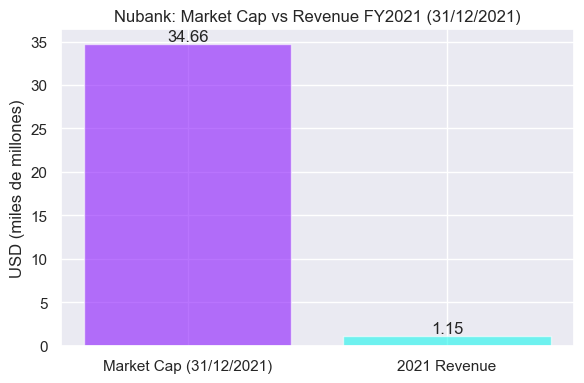

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime


ticker = "NU"
nu = yf.Ticker(ticker)


start_date = datetime.datetime(2021, 12, 21)
end_date = datetime.datetime(2021, 12, 22)  
df_price = yf.download(ticker, start=start_date, end=end_date, progress=False)

if not df_price.empty:
    price_31dec2021 = float(df_price['Close'].iloc[0])
else:
    price_31dec2021 = 0.0


shares_outstanding = nu.info.get('sharesOutstanding', 0)
if shares_outstanding is None:
    shares_outstanding = 0
shares_outstanding = float(shares_outstanding)


market_cap_31dec2021 = price_31dec2021 * shares_outstanding / 1e9


financials = nu.financials
revenue_2021 = 0.0

for col in financials.columns:
    
    if col.year == 2021:
        if "Total Revenue" in financials.index:
            revenue_value = financials.loc["Total Revenue", col]
            if revenue_value is not None:
                revenue_2021 = float(revenue_value) / 1e9  
        break


labels = ['Market Cap (31/12/2021)', '2021 Revenue']
values = [market_cap_31dec2021, revenue_2021]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=['#8b18fe', '#1cf7ed'], alpha=0.6)
plt.ylabel("USD (miles de millones)")
plt.title("Nubank: Market Cap vs Revenue FY2021 (31/12/2021)")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [100]:
import yfinance as yf
import pandas as pd

# Definir el ticker de Nubank
ticker = yf.Ticker("NU")

# Extraer los estados financieros disponibles: Balance, Estado de Resultados y Flujo de Caja
balance_sheet = ticker.balance_sheet
income_statement = ticker.financials
cash_flow = ticker.cashflow

print("=== Balance Sheet ===")
print(balance_sheet)

print("\n=== Income Statement ===")
print(income_statement)

print("\n=== Cash Flow Statement ===")
print(cash_flow)

# Intentemos comparar dos fechas específicas si están disponibles.
# Suponiendo que se dispone de datos para el 31 de diciembre de 2020 (posiblemente pre-OPV)
# y para el 31 de diciembre de 2022 (post-OPV).
if '2020-12-31' in balance_sheet.columns and '2022-12-31' in balance_sheet.columns:
    change_bs = balance_sheet['2022-12-31'] - balance_sheet['2020-12-31']
    print("\n=== Cambios en el Balance Sheet de 2020 a 2022 ===")
    print(change_bs)
else:
    print("\nNo se encontraron ambas fechas (2020 y 2022) en el Balance Sheet. "
          "Yahoo Finance puede tener datos limitados a partir de la OPV.")

if '2020-12-31' in income_statement.columns and '2022-12-31' in income_statement.columns:
    change_is = income_statement['2022-12-31'] - income_statement['2020-12-31']
    print("\n=== Cambios en el Income Statement de 2020 a 2022 ===")
    print(change_is)
else:
    print("\nNo se encontraron ambas fechas (2020 y 2022) en el Income Statement. "
          "Verifique la disponibilidad de datos pre-OPV.")


=== Balance Sheet ===
                                                 2023-12-31     2022-12-31  \
Treasury Shares Number                                  0.0            NaN   
Ordinary Shares Number                         4765937154.0   4694787854.0   
Share Issued                                   4765937154.0   4694787854.0   
Total Debt                                     1173286000.0    605921000.0   
Tangible Book Value                            5712966000.0   4311222000.0   
Invested Capital                               7542729000.0   5476351000.0   
Net Tangible Assets                            5712966000.0   4311222000.0   
Capital Lease Obligations                        36942000.0     20353000.0   
Common Stock Equity                            6406385000.0   4890783000.0   
Total Capitalization                           7429134000.0   5438022000.0   
Total Equity Gross Minority Interest           6406385000.0   4890783000.0   
Minority Interest                         

In [103]:
# Extraer los estados financieros disponibles: Balance, Estado de Resultados y Flujo de Caja
balance_sheet.to_excel('balance contable.xlsx')

In [107]:
hist.iloc[0]['MarketCap']

np.float64(38790493770.46631)

                           Close     MarketCap
Date                                          
2021-12-09 00:00:00-05:00  10.33  3.879049e+10
2021-12-10 00:00:00-05:00  11.85  4.449829e+10
2021-12-13 00:00:00-05:00  10.81  4.059296e+10
2021-12-14 00:00:00-05:00   9.92  3.725089e+10
2021-12-15 00:00:00-05:00  10.01  3.758885e+10


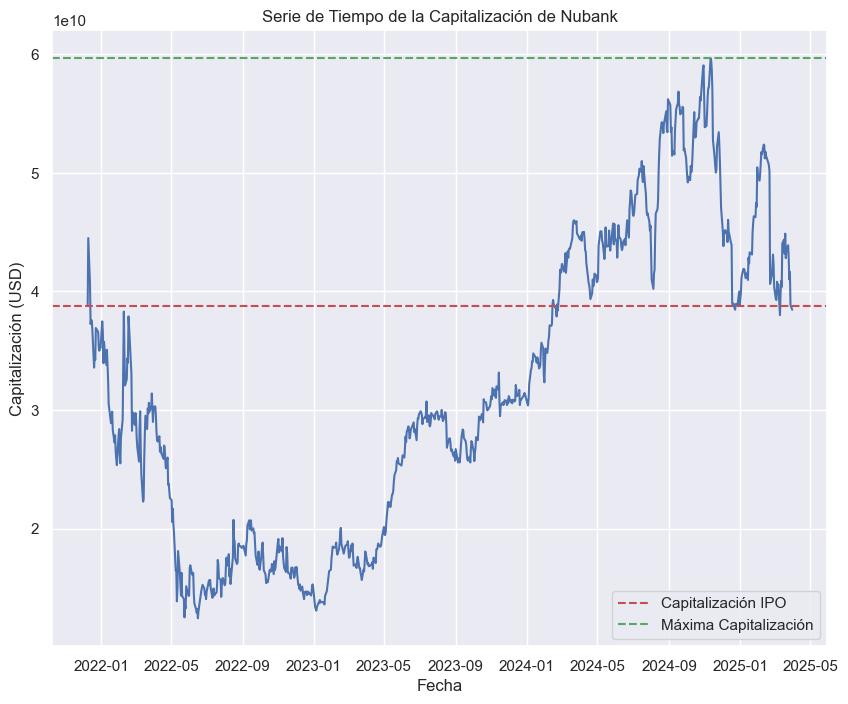

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Definir el ticker de Nubank.
# Para Nubank en NYSE se utiliza "NU"
ticker = "NU"

# Crear objeto Ticker para Nubank.
nubank = yf.Ticker(ticker)

# Obtener datos históricos (por ejemplo, máximo periodo disponible)
hist = nubank.history(period="max")

# Obtener el número de acciones en circulación (sharesOutstanding) a partir de info.
shares_outstanding = nubank.info.get('sharesOutstanding')

if shares_outstanding is None:
    print("No se encontró información sobre las acciones en circulación.")
else:
    # Calcular la capitalización bursátil aproximada (Precio de cierre * acciones en circulación)
    hist['MarketCap'] = hist['Close'] * shares_outstanding

    # Mostrar las primeras filas del DataFrame resultante
    print(hist[['Close', 'MarketCap']].head())

    # Graficar la serie de tiempo de la capitalización bursátil
    plt.figure(figsize=(10, 5))
    plt.plot(hist.index, hist['MarketCap'])
    plt.axhline(y=hist.iloc[0]['MarketCap'], color='r', linestyle='--', label="Capitalización IPO")
    plt.axhline(y=hist['MarketCap'].max(), color='g', linestyle='--', label="Máxima Capitalización")
    plt.title('Serie de Tiempo de la Capitalización de Nubank')
    plt.xlabel('Fecha')
    plt.ylabel('Capitalización (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig("nubank_precio_accion.png", dpi=300, bbox_inches='tight')
    plt.show()


In [34]:
hist.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MarketCap
Date,,,,,,,,
2021-12-09 00:00:00-05:00,11.250,12.24,10.01,10.33,90160800,0.0,0.0,3.879049e+10
2021-12-10 00:00:00-05:00,11.450,11.85,9.80,11.85,50077300,0.0,0.0,4.449829e+10
2021-12-13 00:00:00-05:00,11.100,11.29,10.31,10.81,19658400,0.0,0.0,4.059296e+10
2021-12-14 00:00:00-05:00,10.550,10.58,9.27,9.92,22728100,0.0,0.0,3.725089e+10
2021-12-15 00:00:00-05:00,9.630,10.29,9.42,10.01,12663900,0.0,0.0,3.758885e+10
2021-12-16 00:00:00-05:00,10.450,10.49,9.56,10.00,13981300,0.0,0.0,3.755130e+10
2021-12-17 00:00:00-05:00,9.925,10.17,9.14,9.80,21560800,0.0,0.0,3.680028e+10
2021-12-20 00:00:00-05:00,9.200,9.35,8.75,8.94,15772500,0.0,0.0,3.357086e+10
2021-12-21 00:00:00-05:00,9.020,9.24,8.84,9.23,8402600,0.0,0.0,3.465985e+10


In [44]:
1e+10

10000000000.0

In [36]:
nu_aux = nu_aux[nu_aux.index <= '2022-01-31']

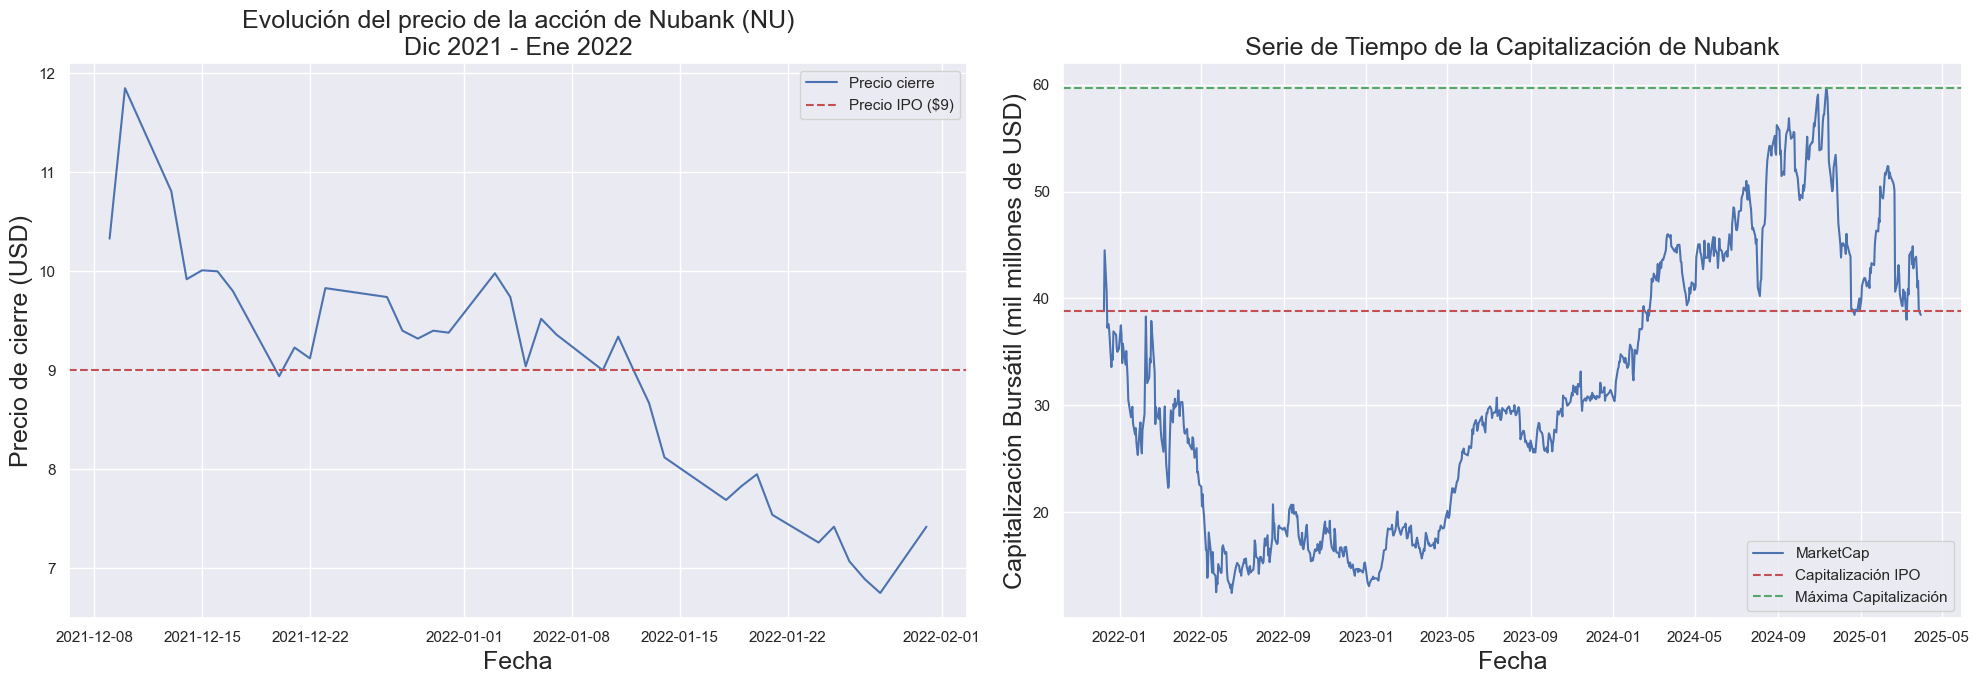

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import yfinance as yf

# Supongamos que ya tienes cargado el DataFrame y definido 'data'
df_precio = pd.DataFrame(data)
df_precio["Fecha"] = pd.to_datetime(df_precio["Fecha"])

# Se asume que 'nu_aux' ya está definido y contiene la serie de precio de cierre de NU.
# Por ejemplo, podría ser:
# nu_aux = df_precio.set_index("Fecha")

# Definir el ticker de Nubank. Para Nubank en NYSE se utiliza "NU"
ticker = "NU"

# Crear objeto Ticker para Nubank y obtener datos históricos
nubank = yf.Ticker(ticker)
hist = nubank.history(period="max")

# Obtener el número de acciones en circulación (sharesOutstanding)
shares_outstanding = nubank.info.get('sharesOutstanding')
if shares_outstanding is None:
    print("No se encontró información sobre las acciones en circulación.")
else:
    # Calcular la capitalización bursátil aproximada
    hist['MarketCap'] = hist['Close'] * shares_outstanding/1e+9

# Crear una figura con dos subgráficas (una al lado de la otra)
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Gráfica 1: Evolución del precio de la acción
ax[0].plot(nu_aux.index, nu_aux['NU'], label="Precio cierre")
ax[0].axhline(y=9.00, color='r', linestyle='--', label="Precio IPO ($9)")
ax[0].set_title("Evolución del precio de la acción de Nubank (NU)\nDic 2021 - Ene 2022", fontsize=18)
ax[0].set_xlabel("Fecha", fontsize=18)
ax[0].set_ylabel("Precio de cierre (USD)", fontsize=18)
ax[0].grid(True)
ax[0].legend()

# Gráfica 2: Serie de Tiempo de la Capitalización de Nubank
ax[1].plot(hist.index, hist['MarketCap'], label="MarketCap")
ax[1].axhline(y=hist.iloc[0]['MarketCap'], color='r', linestyle='--', label="Capitalización IPO")
ax[1].axhline(y=hist['MarketCap'].max(), color='g', linestyle='--', label="Máxima Capitalización")
ax[1].set_title("Serie de Tiempo de la Capitalización de Nubank", fontsize=18)
ax[1].set_xlabel("Fecha", fontsize=18)
ax[1].set_ylabel("Capitalización Bursátil (mil millones de USD)", fontsize=18)
ax[1].grid(True)
ax[1].legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2d'))

# Ajustar el layout para que no se sobrepongan los elementos
plt.tight_layout()

# Guardar la figura combinada si se desea
plt.savefig("nubank_combined.png", dpi=300, bbox_inches='tight')

plt.show()
